In [1]:
import pandas as pd
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

## Deep fruits

### Read txt annotation

In [19]:
dir_path = './data/deep_fruits'
names = os.listdir(dir_path)
names = ['apple', 'avocado', 'mango','orange', 'rockmelon', 'strawberry']
# names = ['apple', 'avocado', 'mango', 'orange', 'strawberry', 'capsicum', 'rockmelon']

In [26]:
df = pd.DataFrame()
max_num = 400
for folder in os.listdir(dir_path):
    num_boxes = 0
    if folder not in names:
        continue
    for stage in ['train', 'test']:
        f = open(os.path.join(dir_path, folder, f'{stage}_RGB.txt'), 'r')
        line = f.readline()
        while line and num_boxes < max_num:
            filename = line.split(' ')[0]
            if stage == 'test':
                filename = filename.replace('TRAIN', 'TEST')
            if not os.path.exists(os.path.join(dir_path, folder, filename)):
                line = f.readline()
                continue
            N = int(line.split(' ')[1])
            num_boxes += N
            for i in range(N):
                instance = list(map(float, line.split(' ')[2+i*6:2+(i+1)*6]))
                bbox = instance[:4]
                pt1 = bbox[:2]
                pt2 = bbox[2:]
                bbox = pt1 + [pt2[0] - pt1[0], pt2[1] - pt1[1]]
                df_i = pd.DataFrame({'filename': os.path.join(folder, filename),
                                'full_filename': os.path.join(dir_path, folder, filename),
                                'bbox': [bbox],
                                'category': folder,
                                })
                df = pd.concat([df, df_i])
            line = f.readline()
#     break
f.close()
df

,filename,full_filename,bbox,category
0,strawberry/TRAIN_RGB/1460105322_1756a2ed7f.png,./data/deep_fruits/strawberry/TRAIN_RGB/146010...,"[24.0, 187.0, 158.0, 166.0]",strawberry
0,strawberry/TRAIN_RGB/1460105322_1756a2ed7f.png,./data/deep_fruits/strawberry/TRAIN_RGB/146010...,"[125.0, 117.0, 164.0, 204.0]",strawberry
0,strawberry/TRAIN_RGB/1460105322_1756a2ed7f.png,./data/deep_fruits/strawberry/TRAIN_RGB/146010...,"[280.0, 177.0, 75.0, 98.0]",strawberry
0,strawberry/TRAIN_RGB/1460105322_1756a2ed7f.png,./data/deep_fruits/strawberry/TRAIN_RGB/146010...,"[306.0, 47.0, 156.0, 199.0]",strawberry
0,strawberry/TRAIN_RGB/1460105322_1756a2ed7f.png,./data/deep_fruits/strawberry/TRAIN_RGB/146010...,"[445.0, 47.0, 52.0, 96.0]",strawberry
...,...,...,...,...
0,orange/TEST_RGB/n12710693_12225.png,./data/deep_fruits/orange/TEST_RGB/n12710693_1...,"[515.0, 68.0, 244.0, 217.0]",orange
0,orange/TEST_RGB/n12710693_12225.png,./data/deep_fruits/orange/TEST_RGB/n12710693_1...,"[624.0, 347.0, 244.0, 235.0]",orange
0,orange/TEST_RGB/n12710693_12225.png,./data/deep_fruits/orange/TEST_RGB/n12710693_1...,"[480.0, 488.0, 213.0, 224.0]",orange
0,orange/TEST_RGB/n12710693_12225.png,./data/deep_fruits/orange/TEST_RGB/n12710693_1...,"[44.0, 433.0, 224.0, 224.0]",orange


In [27]:
df['category'].value_counts()

mango         401
apple         359
strawberry    348
orange        274
avocado       178
rockmelon     137
Name: category, dtype: int64

In [28]:
df['filename'].nunique()

329

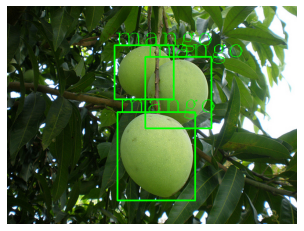

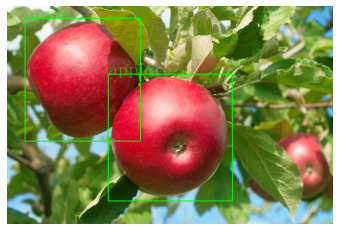

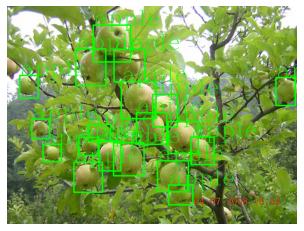

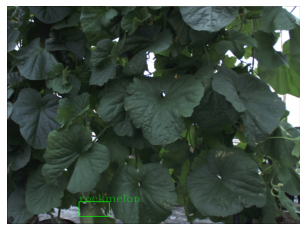

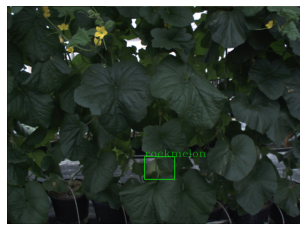

In [29]:
for i, filename in enumerate(np.random.choice(df['full_filename'].unique(), 5, replace=False)):
#     print(filename)
    img = cv2.imread(f'{filename}')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    bboxes = df[df['full_filename'] == filename]['bbox']
    for i, bbox in enumerate(bboxes):
        df['bool_bbox'] = df['bbox'].apply(lambda x: x == bbox)
        orig_name = df[(df['full_filename'] == filename) & (df['bool_bbox'])]['category'].values[0]
        # target_name = df[(df['full_filename'] == filename) & (df['bool_bbox'])]['target_name'].values[0]
        bbox = list(map(int, bbox))
        pt1 = bbox[:2]
        # pt2 = bbox[2:]       
        pt2 = [pt1[0] + bbox[2], pt1[1] + bbox[3]]        
        cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=2)
        cv2.putText(img, text=orig_name, org=pt1, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=1.5, color=(0, 255, 0))
#     imname = filename.rsplit('/')[-1]
#     imname_new = dir_path + imname.split('.')[0] + f'_{i}.' + imname.split('.')[1]
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [30]:
dir_path = './data/deep_fruits/annotation'
if not os.path.isdir(dir_path):
    os.mkdir(dir_path)    
files = df['filename'].unique()
f = open(f'{dir_path}/fruits_test.txt', 'w')
for filename in files:
    f.write(f'{filename}\n')
    df_i = df[df['filename'] == filename]
    f.write(f'{df_i.shape[0]}\n')
    for _, row in df_i.iterrows():
        bbox = row['bbox']
        category = row['category']
        f.write(f"{' '.join(map(str, bbox))} {category}")
        f.write('\n')
f.close()        

### To detectron format

In [100]:
# from detectron2.structures import BoxMode
img_dir = './data/deep_fruits'
names = ['apple', 'avocado', 'mango', 'orange', 'strawberry']
name2label = dict(zip(names, range(len(names))))

def get_deep_fruits_dicts(df, img_dir):
    df = pd.read_csv(f'{img_dir}/annotation.csv')
    dataset_dicts = []
    for idx, filename in enumerate(df['filename'].unique()):
        record = {}
        
        full_filename = os.path.join(img_dir, filename)
        height, width = cv2.imread(full_filename).shape[:2]
        
        record["file_name"] = full_filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = df[df['filename'] == filename]
        objs = []
        for _, anno in annos.iterrows():
            obj = {
                "bbox": list(map(float, anno['bbox'][1:-1].split(', '))),
#                 "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(anno['label']),
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
#         break
    return dataset_dicts


In [101]:
get_deep_fruits_dicts(df, img_dir)

[{'file_name': './data/deep_fruits\\apple\\TRAIN_RGB/1.png',
  'image_id': 0,
  'height': 480,
  'width': 852,
  'annotations': [{'bbox': [199.0, 15.0, 347.0, 144.0], 'category_id': 0},
   {'bbox': [128.0, 132.0, 285.0, 283.0], 'category_id': 0},
   {'bbox': [358.0, 149.0, 512.0, 297.0], 'category_id': 0},
   {'bbox': [486.0, 208.0, 621.0, 356.0], 'category_id': 0},
   {'bbox': [548.0, 299.0, 692.0, 445.0], 'category_id': 0},
   {'bbox': [374.0, 270.0, 518.0, 393.0], 'category_id': 0}]},
 {'file_name': './data/deep_fruits\\apple\\TRAIN_RGB/2010-12-07-05-26-38_1291641998.png',
  'image_id': 1,
  'height': 525,
  'width': 700,
  'annotations': [{'bbox': [252.0, 128.0, 357.0, 235.0], 'category_id': 0},
   {'bbox': [544.0, 55.0, 617.0, 134.0], 'category_id': 0},
   {'bbox': [320.0, 309.0, 416.0, 407.0], 'category_id': 0},
   {'bbox': [419.0, 375.0, 507.0, 469.0], 'category_id': 0},
   {'bbox': [146.0, 340.0, 234.0, 430.0], 'category_id': 0},
   {'bbox': [114.0, 232.0, 205.0, 324.0], 'categ

In [ ]:
from detectron2.data import DatasetCatalog

DatasetCatalog.register("deep_fruits", get_deep_fruits_dicts)
# later, to access the data:
data: List[Dict] = DatasetCatalog.get("deep_fruits")

In [ ]:
from detectron2.data import MetadataCatalog

MetadataCatalog.get("deep_fruits").thing_classes = names